In [1]:
import torch
import torch.utils.data as data
from torchvision import transforms, utils
from PIL import Image
import numpy as np

class LFLSegDataset(data.Dataset):
	"""
	LFLSeg Dataset
	Class: ['full_leaf': 0, 'partial_leaf': 1, 'non_leaf': 2]
	"""
	def __init__(self, txt_path, transform=None):
		"""
		Args:
			txt_path (string): Path to the txt file with annotations.
			transform (callable, optional): Optional transform to be applied
				on a sample.
		"""
		with open(txt_path, encoding="utf-8") as f:
			listpath = f.readlines()
		
		listpath = [x.strip() for x in listpath]
		samples = []

		# label_list = []
		for line in listpath:
			filepath, label = line.split(",")[0],line.split(",")[1]
			filepath = filepath.encode('utf-8')
			samples.append((filepath, label))
			
		self.samples = samples

		self.transform = transform

	def __len__(self):
		return 10

	def __getitem__(self, idx):
		filepath, label = self.samples[idx]
		img = Image.open(filepath)
		# If an image is grayscale, convert to RGB
		if(img.mode != 'RGB'):
			img = img.convert('RGB')
		
		if self.transform:
			img = self.transform(img)
			
		label = torch.tensor(int(label))

		return img, label

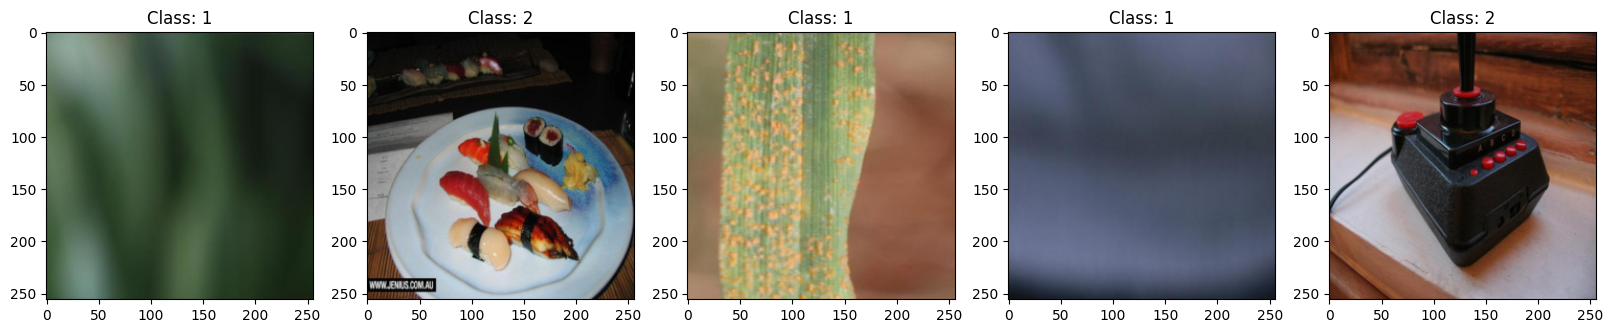

In [3]:
import matplotlib.pyplot as plt

# Define the path to your annotation file
txt_path = "train.txt"

# Define any transformations you want to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to 256x256
    transforms.ToTensor()  # Convert the image to a PyTorch tensor
])

# Initialize the dataset
dataset = LFLSegDataset(txt_path, transform=transform)

# Visualize some samples
num_samples_to_visualize = 5
fig, axes = plt.subplots(1, num_samples_to_visualize, figsize=(20, 4))

for i in range(num_samples_to_visualize):
    # Get an image and its corresponding label from the dataset
    image, label = dataset[i]

    # Convert the PyTorch tensor to a NumPy array and transpose it to the correct shape for visualization
    image = image.numpy().transpose((1, 2, 0))

    # Display the image
    axes[i].imshow(image)
    axes[i].set_title(f"Class: {label.item()}")

plt.show()


In [ ]:
fig, axes = plt.subplots(1,1, figsize=(20, 4))
image, label = dataset[8000]

    # Convert the PyTorch tensor to a NumPy array and transpose it to the correct shape for visualization
image = image.numpy().transpose((1, 2, 0))

    # Display the image
axes.imshow(image)
axes.set_title(f"Class: {label.item()}")

plt.show()


In [ ]:
import os.path
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms

# Define arguments
gpu = "0"  # GPU index
epoch = 100  # Number of epochs
input_size = 224  # Input size
batch_size = 128  # Batch size
train_dataset = 'train.txt'  # Path to train dataset
test_dataset = 'test.txt'  # Path to test dataset
modelname = 'resnet101_LFLSeg_v1'  # Model name
output = 'trained_models/'  # Output folder

os.environ['CUDA_VISIBLE_DEVICES'] = gpu

TRAIN = 'train'
TEST = 'test'

print("Train data: %s" % train_dataset)
print("Test data: %s" % test_dataset)

# Save trained models (classifiers)
save_folder = output
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
print('Save trained models to: ' + save_folder)

# Class: ['full_leaf': 0, 'partial_leaf': 1, 'non_leaf': 2]

def train_model(model, log_filename, optimizer, criterion, scheduler, dataloaders, num_epochs=epoch):
    since = time.time()

    best_acc = 0.0
    log_file = open(os.path.join(save_folder,'train_log_' + log_filename + '.txt'), 'w')

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 20)

        log_file.write('Epoch {}/{}'.format(epoch, num_epochs) + '\n')
        log_file.write('-' * 20 + '\n')

        # Each epoch has a training and test phase
        for phase in [TRAIN, TEST]:
            if phase == 'train':
                optimizer.step()  # Step of optimization
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            log_file.write('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc) + '\n')

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc

                ## Saving model
                if isinstance(model, nn.DataParallel):
                    temp_model = model.module

                state_dict = temp_model.state_dict()
                for key, param in state_dict.items():
                    state_dict[key] = param.cpu()
                torch.save(state_dict, os.path.join(save_folder, str(epoch) + '_best_model_' + log_filename + '.pth'))
                print("Saved best_model at epoch {}".format(epoch))
                log_file.write('Saved best_model at epoch {}\n'.format(epoch))

        # Saving model every 10 epoch
        if(epoch % 10 == 0):
            if isinstance(model, nn.DataParallel):
                temp_model = model.module

            state_dict = temp_model.state_dict()
            for key, param in state_dict.items():
                state_dict[key] = param.cpu()
            torch.save(state_dict, os.path.join(save_folder, 'trained_' + log_filename + '_%d.pth' % epoch))
            print()
            log_file.write('\n')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

def main():
    data_transforms = {
        TRAIN: transforms.Compose([
            transforms.RandomResizedCrop(size=input_size, scale=(0.8, 1.0), interpolation=3),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),

        TEST: transforms.Compose([
            transforms.Resize(size=(input_size, input_size), interpolation=3),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    }

    image_datasets = {
        TRAIN: LFLSegDataset(
            txt_path=train_dataset,
            transform=data_transforms[TRAIN]
        ),
        TEST: LFLSegDataset(
            txt_path=test_dataset,
            transform=data_transforms[TEST]
        )
    }

    dataloaders = {
        x: torch.utils.data.DataLoader(
            image_datasets[x], batch_size=batch_size,
            shuffle=True, num_workers=32
        )
        for x in [TRAIN, TEST]
    }

    model_ft = models.resnet101(pretrained=True)

    model_name = modelname
    print(model_name)
    print(train_dataset)
    print("Number of epoch: %d" % epoch)

    # Replace final layer with 3 outputs (full leaf, partial leaf, non-leaf)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 3)

    for param in model_ft.parameters():
        param.requires_grad = True

    model_ft = nn.DataParallel(model_ft)
    model_ft = model_ft.to('cpu')

    criterion = nn.CrossEntropyLoss().to('cpu')

    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    train_model(model_ft, model_name, optimizer_ft, criterion, exp_lr_scheduler, dataloaders)


if __name__ == '__main__':
    main()


Train data: train.txt
Test data: test.txt
Save trained models to: trained_models/


C:\Users\nrgaj\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:561: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
C:\Users\nrgaj\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nrgaj\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 

resnet101_LFLSeg_v1
train.txt
Number of epoch: 100
Epoch 1/100
--------------------


Accuracy of the network on the test images: 100.00%


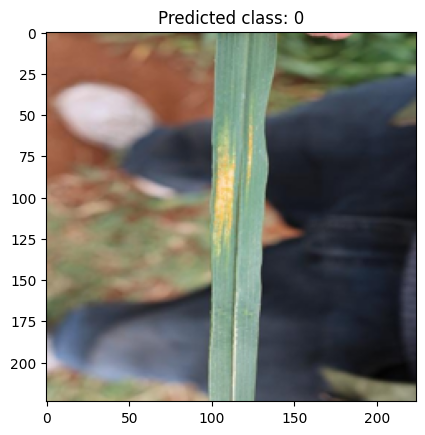

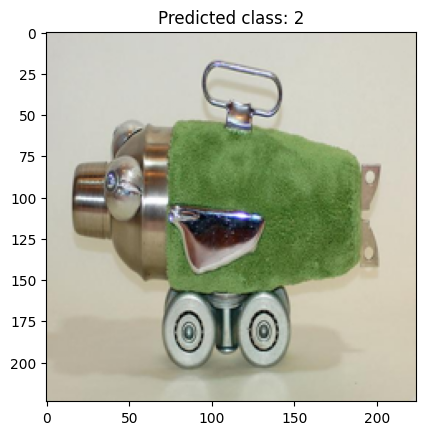

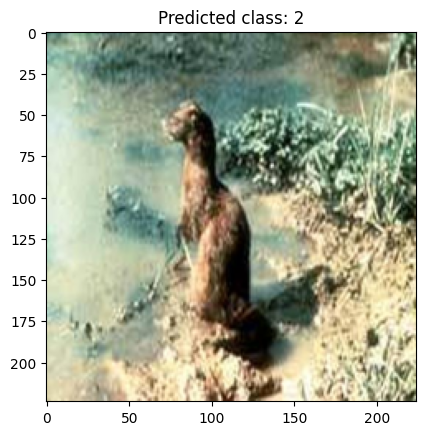

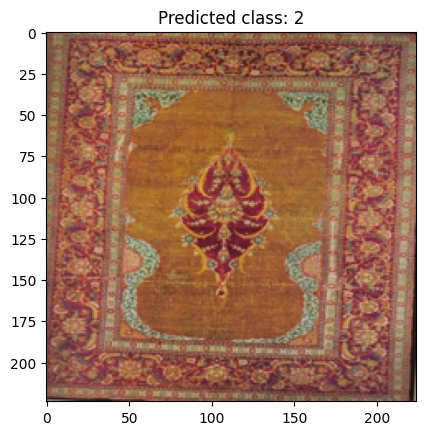

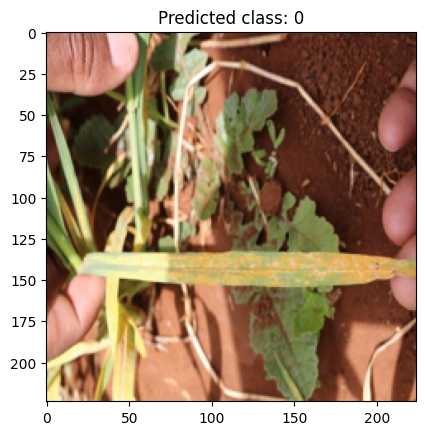

In [16]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import DataLoader

input_size = 224  # Input size
batch_size = 128  # Batch size
# Set your device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to the saved model
model_path = "20_best_model_resnet101_LFLSeg_v1.pth"

# Define your test dataset and dataloader
test_dataset = LFLSegDataset(
    txt_path='test.txt',
    transform=transforms.Compose([
        transforms.Resize(size=(input_size, input_size), interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the model
model = models.resnet101(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # Assuming you have 3 classes

# Load the model state dictionary
state_dict = torch.load(model_path, map_location=device)

# If the model was trained using nn.DataParallel, remove the "module." prefix from the keys
if 'module.' in list(state_dict.keys())[0]:
    state_dict = {k[7:]: v for k, v in state_dict.items()}

# Load the state dictionary
model.load_state_dict(state_dict)

# Wrap the model with nn.DataParallel for testing if necessary
model = nn.DataParallel(model)

# Move the model to the appropriate device
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Initialize variables for tracking accuracy
correct = 0
total = 0

# Initialize lists to store predicted classes and images
predicted_classes = []
images_list = []

# Iterate through test dataset and compute accuracy
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append predicted classes and images to lists
        predicted_classes.extend(predicted.cpu().numpy())
        images_list.extend(images.cpu().numpy())

# Calculate accuracy
accuracy = 100 * correct / total
print('Accuracy of the network on the test images: {:.2f}%'.format(accuracy))

# Function to display images with their predicted classes
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Display a few images with their predicted classes
num_images_to_display = 5
for i in range(num_images_to_display):
    image = images_list[i]
    label = predicted_classes[i]
    #
    imshow(image, 'Predicted class: {}'.format(label))


In [1]:
#!/usr/bin/env python
# coding: utf-8
#
# Author:   Kazuto Nakashima
# URL:      http://kazuto1011.github.io
# Created:  2017-05-26

from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F


class _PropagationBase(object):
	def __init__(self, model):
		super(_PropagationBase, self).__init__()
		self.device = next(model.parameters()).device
		self.model = model
		self.image = None

	def _encode_one_hot(self, idx):
		one_hot = torch.FloatTensor(1, self.preds.size()[-1]).zero_()
		one_hot[0][idx] = 1.0
		return one_hot.to(self.device)

	def forward(self, image):
		self.image = image.requires_grad_()
		self.model.zero_grad()
		self.preds = self.model(self.image)
		self.probs = F.softmax(self.preds, dim=1)[0]
		self.prob, self.idx = self.probs.sort(0, True)
		return self.prob, self.idx

	def backward(self, idx):
		one_hot = self._encode_one_hot(idx)
		self.preds.backward(gradient=one_hot, retain_graph=True)


class BackPropagation(_PropagationBase):
	def generate(self):
		output = self.image.grad.detach().cpu().numpy()
		return output.transpose(0, 2, 3, 1)[0]


class GuidedBackPropagation(BackPropagation):
	def __init__(self, model):
		super(GuidedBackPropagation, self).__init__(model)

		def func_b(module, grad_in, grad_out):
			# Cut off negative gradients
			if isinstance(module, nn.ReLU):
				return (torch.clamp(grad_in[0], min=0.0), )

		for module in self.model.named_modules():
			module[1].register_backward_hook(func_b)


class Deconvolution(BackPropagation):
	def __init__(self, model):
		super(Deconvolution, self).__init__(model)

		def func_b(module, grad_in, grad_out):
			# Cut off negative gradients
			if isinstance(module, nn.ReLU):
				return (torch.clamp(grad_out[0], min=0.0), )

		for module in self.model.named_modules():
			module[1].register_backward_hook(func_b)


class GradCAM(_PropagationBase):
	def __init__(self, model):
		super(GradCAM, self).__init__(model)
		self.all_fmaps = OrderedDict()
		self.all_grads = OrderedDict()

		def func_f(module, input, output):
			self.all_fmaps[id(module)] = output.detach()

		def func_b(module, grad_in, grad_out):
			self.all_grads[id(module)] = grad_out[0].detach()

		for module in self.model.named_modules():
			module[1].register_forward_hook(func_f)
			module[1].register_backward_hook(func_b)

	def _find(self, outputs, target_layer):
		for key, value in outputs.items():
			for module in self.model.named_modules():
				if id(module[1]) == key:
					if module[0] == target_layer:
						return value
		raise ValueError('Invalid layer name: {}'.format(target_layer))

	def _normalize(self, grads):
		l2_norm = torch.sqrt(torch.mean(torch.pow(grads, 2))) + 1e-5
		return grads / l2_norm

	def _compute_grad_weights(self, grads):
		grads = self._normalize(grads)
		return F.adaptive_avg_pool2d(grads, 1)

	def generate(self, target_layer):
		fmaps = self._find(self.all_fmaps, target_layer)
		grads = self._find(self.all_grads, target_layer)
		weights = self._compute_grad_weights(grads)

		gcam = (fmaps[0] * weights[0]).sum(dim=0)
		gcam = torch.clamp(gcam, min=0.)

		gcam -= gcam.min()
		gcam /= gcam.max()

		return gcam.detach().cpu().numpy()

In [6]:
import os
from PIL import Image
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms

# Import GradCAM module from the provided file
# from grad_cam import GradCAM

def save_gradcam(save_path, gcam, raw_image, threshold=0.35, is_segment=False):
    raw_image = np.asarray(raw_image)[:, :, ::-1].copy()
    raw_image = cv2.resize(raw_image, (256, 256))
    h, w, _ = raw_image.shape
    gcam = cv2.resize(gcam, (w, h))

    # Segment the leaf with the given threshold
    if is_segment:
        background_mask = 1.0-(gcam>=threshold)
        foreground_mask =  gcam>=threshold

        foreground_mask = np.stack((foreground_mask, foreground_mask, foreground_mask), axis=2)
        foreground = foreground_mask * raw_image
        foreground = foreground / foreground.max() * 255.0

        cv2.imwrite(save_path, np.uint8(foreground))
    
    else: # Just output the GradCAM heatmap with given threshold
        gcam = gcam*(gcam>=threshold)
        gcam = cv2.applyColorMap(np.uint8(gcam * 255.0), cv2.COLORMAP_JET)
        gcam = gcam.astype(np.float32) + raw_image.astype(np.float32)
        gcam = gcam / gcam.max() * 255.0
        cv2.imwrite(save_path, np.uint8(gcam))

    print('Saved result at: %s' % save_path)

# Define the paths and parameters
input_folder = 'original_stripe_rust/'
output_folder = 'original_output_stripe_rust'
threshold = 0.65
segment = True
target_layer = 'layer4.2'

# Set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the LFLSeg module (ResNet-101 backbone)
LFLSeg_model = models.resnet101(pretrained=False)
num_ftrs = LFLSeg_model.fc.in_features
LFLSeg_model.fc = nn.Linear(num_ftrs, 3)  # Replace final layer with 3 outputs (full leaf, partial leaf, non-leaf)

# Load the pretrained weights
load_path = '20_best_model_resnet101_LFLSeg_v1.pth'
LFLSeg_model.load_state_dict(torch.load(load_path, map_location=device))

LFLSeg_model.to(device)
LFLSeg_model.eval()

# Load the GradCAM function
gcam = GradCAM(model=LFLSeg_model)

# If output folder does not exist, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate over each image in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".jpg") or filename.endswith(".JPG"):
        input_image_path = os.path.join(input_folder, filename)
        raw_image = Image.open(input_image_path).convert('RGB')

        # Preprocess the input image
        image = transforms.Compose([
            transforms.Resize(size=(224, 224), interpolation=3),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])(raw_image).unsqueeze(0)

        # Move the image to the appropriate device
        image = image.to(device)

        # Perform inference and generate GradCAM
        probs, idx = gcam.forward(image)
        gcam.backward(idx=0)
        output = gcam.generate(target_layer=target_layer)

        # For demonstration, let's just create a dummy output for now
        

        # Save the GradCAM result
        save_path = os.path.join(output_folder, filename[:-4] + '_gcam.png')
        save_gradcam(save_path, output, raw_image, threshold=threshold, is_segment=segment)

        print('Saved result at:', save_path)


Saved result at: original_output_stripe_rust\lolr(1)_gcam.png
Saved result at: original_output_stripe_rust\lolr(1)_gcam.png
Saved result at: original_output_stripe_rust\lolr(10)_gcam.png
Saved result at: original_output_stripe_rust\lolr(10)_gcam.png
Saved result at: original_output_stripe_rust\lolr(100)_gcam.png
Saved result at: original_output_stripe_rust\lolr(100)_gcam.png
Saved result at: original_output_stripe_rust\lolr(101)_gcam.png
Saved result at: original_output_stripe_rust\lolr(101)_gcam.png
Saved result at: original_output_stripe_rust\lolr(102)_gcam.png
Saved result at: original_output_stripe_rust\lolr(102)_gcam.png
Saved result at: original_output_stripe_rust\lolr(103)_gcam.png
Saved result at: original_output_stripe_rust\lolr(103)_gcam.png
Saved result at: original_output_stripe_rust\lolr(104)_gcam.png
Saved result at: original_output_stripe_rust\lolr(104)_gcam.png
Saved result at: original_output_stripe_rust\lolr(105)_gcam.png
Saved result at: original_output_stripe_rust\l

Saved result at: original_output_stripe_rust\lolr(158)_gcam.png
Saved result at: original_output_stripe_rust\lolr(158)_gcam.png
Saved result at: original_output_stripe_rust\lolr(159)_gcam.png
Saved result at: original_output_stripe_rust\lolr(159)_gcam.png
Saved result at: original_output_stripe_rust\lolr(16)_gcam.png
Saved result at: original_output_stripe_rust\lolr(16)_gcam.png
Saved result at: original_output_stripe_rust\lolr(160)_gcam.png
Saved result at: original_output_stripe_rust\lolr(160)_gcam.png
Saved result at: original_output_stripe_rust\lolr(161)_gcam.png
Saved result at: original_output_stripe_rust\lolr(161)_gcam.png
Saved result at: original_output_stripe_rust\lolr(162)_gcam.png
Saved result at: original_output_stripe_rust\lolr(162)_gcam.png
Saved result at: original_output_stripe_rust\lolr(163)_gcam.png
Saved result at: original_output_stripe_rust\lolr(163)_gcam.png
Saved result at: original_output_stripe_rust\lolr(164)_gcam.png
Saved result at: original_output_stripe_ru

Saved result at: original_output_stripe_rust\lolr(29)_gcam.png
Saved result at: original_output_stripe_rust\lolr(29)_gcam.png
Saved result at: original_output_stripe_rust\lolr(3)_gcam.png
Saved result at: original_output_stripe_rust\lolr(3)_gcam.png
Saved result at: original_output_stripe_rust\lolr(30)_gcam.png
Saved result at: original_output_stripe_rust\lolr(30)_gcam.png
Saved result at: original_output_stripe_rust\lolr(31)_gcam.png
Saved result at: original_output_stripe_rust\lolr(31)_gcam.png
Saved result at: original_output_stripe_rust\lolr(32)_gcam.png
Saved result at: original_output_stripe_rust\lolr(32)_gcam.png
Saved result at: original_output_stripe_rust\lolr(33)_gcam.png
Saved result at: original_output_stripe_rust\lolr(33)_gcam.png
Saved result at: original_output_stripe_rust\lolr(34)_gcam.png
Saved result at: original_output_stripe_rust\lolr(34)_gcam.png
Saved result at: original_output_stripe_rust\lolr(35)_gcam.png
Saved result at: original_output_stripe_rust\lolr(35)_gca

Saved result at: original_output_stripe_rust\lolr(89)_gcam.png
Saved result at: original_output_stripe_rust\lolr(89)_gcam.png
Saved result at: original_output_stripe_rust\lolr(9)_gcam.png
Saved result at: original_output_stripe_rust\lolr(9)_gcam.png
Saved result at: original_output_stripe_rust\lolr(90)_gcam.png
Saved result at: original_output_stripe_rust\lolr(90)_gcam.png
Saved result at: original_output_stripe_rust\lolr(91)_gcam.png
Saved result at: original_output_stripe_rust\lolr(91)_gcam.png
Saved result at: original_output_stripe_rust\lolr(92)_gcam.png
Saved result at: original_output_stripe_rust\lolr(92)_gcam.png
Saved result at: original_output_stripe_rust\lolr(93)_gcam.png
Saved result at: original_output_stripe_rust\lolr(93)_gcam.png
Saved result at: original_output_stripe_rust\lolr(94)_gcam.png
Saved result at: original_output_stripe_rust\lolr(94)_gcam.png
Saved result at: original_output_stripe_rust\lolr(95)_gcam.png
Saved result at: original_output_stripe_rust\lolr(95)_gca